# Preliminary Data Wrangling

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import requests
import zipfile 
import os 

%matplotlib inline

### DataFrame and CSV filesize issues
I originally had potential issues loading and concatenating so many csv files into one large dataframe, the saved master csv was 500Mb, it took up far to much working memory. I opted instead to write a function that would take a month as an integer between 1 and 12 inclusive and read the specific csv for that month and return that month's data as a dataframe. 

In [3]:
#Takes an integer value between 1 and 12 inclusive, returns a dataframe of bikeshare data for that month 

#PLEASE NOTE - after initial test of loading monthly data - 
#made adjustment to start_time and end_time columns in function so they are datetime types
#user_type was changed to categorical 
#bike_id was changed to non-numeric type 
#start_station and end_end station were changed to non-numeric types - they stay as encoded as float strings though
#latlongs were changed to non-numeric types 


#DOES NOT REMOVE MISSING ROW DATA 
def bikeshare_monthly(month):
    year = "2019"
    filetail = "-tripdata.csv"
    if(month < 10):
        month_str = "0"+str(month)
    else:
        month_str = str(month)
    if(month < 5):
        business_name = "-fordgobike"
    else:
        business_name = "-baywheels"
    file_name = year + month_str + business_name + filetail
    df = pd.read_csv(file_name)
    df.fillna(np.nan, inplace=True)
    
    #formatting variable types
    df.start_time = pd.to_datetime(df.start_time)
    df.end_time = pd.to_datetime(df.end_time)
    df.user_type = df.user_type.astype('category')
    df.bike_id = df.bike_id.astype('str')
    df.start_station_latitude = df.start_station_latitude.astype('str')
    df.start_station_longitude = df.start_station_longitude.astype('str')
    df.end_station_latitude = df.end_station_latitude.astype('str')
    df.end_station_longitude = df.end_station_longitude.astype('str')
    #df.start_station_id = df.start_station_id.astype('str')
    #df.end_station_id = df.end_station_id.astype('str')
    df.drop(columns='bike_share_for_all_trip', inplace=True)
    return df

In [36]:
#download zip files containing bikeshare data 
base_url = "https://s3.amazonaws.com/baywheels-data/"
year = "2019"
business0_name = "-fordgobike"
business1_name = "-baywheels"
tail = "-tripdata.csv.zip"

#iterate through each month 1 -> 12
for i in range(1, 13):
    #business name changes in April (04)
    if(i < 5):
        tail_url = business0_name + tail
    else:
        tail_url = business1_name + tail
    if(i < 10):
        month = "0" + str(i)
    else:
        month = str(i)
    #join strings to make download path 
    url = base_url + year + month + tail_url
    filename = year + month + tail_url
    response = requests.get(url)
    #if get request returned OK, write file 
    print(response.status_code)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            file.write(response.content)
            print("zip file saved...")

200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...
200
zip file saved...


In [37]:
#now extract each file
csv_end = "-tripdata.csv"
temp = []
for i in range(1, 13):
    #business name changes in April (04)
    if(i < 5):
        tail_url = business0_name + tail
        csv_tail = business0_name + csv_end
    else:
        tail_url = business1_name + tail
        csv_tail = business1_name + csv_end
    if(i < 10):
        month = "0" + str(i)
    else:
        month = str(i)
    filename = year + month + tail_url 
    with zipfile.ZipFile(filename, 'r') as myzip:
        myzip.extractall()

In [38]:
#tidy up directory and delete zip files
file_tail = "-tripdata"
zip_tail = ".zip"
csv_tail = ".csv"
for i in range(1, 13):
    if(i < 10):
        month = "0" + str(i)
    else:
        month = str(i)
    #the business name changes in April, the file data also changes
    if(i < 5):
        csv_name = year + month + business0_name + file_tail + csv_tail
    else:
        csv_name = year + month + business1_name + file_tail + csv_tail
    zip_name = csv_name + zip_tail
    os.remove(zip_name)

In [4]:
#test the loading function is working 
jan = bikeshare_monthly(1)

In [5]:
print(jan.shape)
print(jan.info())
print(jan.head())
print(jan.user_type.value_counts())

(192082, 13)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192082 entries, 0 to 192081
Data columns (total 13 columns):
duration_sec               192082 non-null int64
start_time                 192082 non-null datetime64[ns]
end_time                   192082 non-null datetime64[ns]
start_station_id           191834 non-null float64
start_station_name         191834 non-null object
start_station_latitude     192082 non-null object
start_station_longitude    192082 non-null object
end_station_id             191834 non-null float64
end_station_name           191834 non-null object
end_station_latitude       192082 non-null object
end_station_longitude      192082 non-null object
bike_id                    192082 non-null object
user_type                  192082 non-null category
dtypes: category(1), datetime64[ns](2), float64(2), int64(1), object(7)
memory usage: 17.8+ MB
None
   duration_sec              start_time                end_time  \
0         80825 2019-01-31 17:57:44.613 

## Dataset features 

There are 14 features, with the number of rows varying depending on the month. For this subset there were 192082 bike hires for the month of January. The majority of the columns are identifying information to do with the start and end stations, like their id, latitude and longitude coordinates and the station name. The rental times and the duration of hire are self-explanatory 

- user_type is categorical and takes one of two values, either Customer (Casual) or Subscriber (Member).  

- bike_share_for_all_trip is the final column but I made the decision to drop it due to the lack of information to its relevance

## Main features of interest

My primary focus will be on the start and end stations. It is my assumption that bikeshare stations would hardly be a self regulating system. Some stations will get more use than others. Rental bikes will be moved from one station to another. This one directional flow of bikes will create build ups at certain stations. From a cursory glance at Subscriber and Customer use numbers. It is predominantly members that use the service. The business needs to ensure that bikes will always be available at each station for people to use. 

 - Which stations should the company take bikes from to top up stations that are empty?
 - Are there consistent patterns of bike flows each month or does it change throughout the year?

## Supporting features 

Because bike riding is an outdoor activity, I would expect there to be changes in demand depending on the time of year. start_time is an important feature in explaining this. I'm also considering finding a separate source for average weather and temperature data over the year of 2019 as it could provide more insight into ride numbers. Much of the analysis will have to be done through feature engineering. 

> Measuring bike_flow is chief among these - we'll start at a baseline of zero for each registered station and for each trip we -1 from the start station and +1 to the end station. These values will continue to climb or descend depending on how bikes are added or removed. Regardless of the actual number of bikes in circulation, it gives a clear picture of the system state at the end of each month. 

- The large number of Subscribers indicates that most hires are from Bay Area locals, are they commuting from residental areas to work or using the bikes as final leg transport? 
- This raises the additional question as to what the weekly distribution of bike hires is, is it mainly weekly commutes or do people use it as weekend transport for getting around the city?

## Univariate Exploration 

Firstly lets look at the distribution of hire duration 

### Distribution of hire duration

In [6]:
#this will give us an idea of our bin sizes 
jan.describe()

,duration_sec,start_station_id,end_station_id
count,192082.000000,191834.000000,191834.000000
mean,750.952473,132.841639,131.218700
std,1672.433843,109.662417,109.546275
min,61.000000,3.000000,3.000000
25%,333.000000,43.000000,41.000000
50%,528.000000,98.000000,95.000000
75%,821.000000,211.000000,203.000000
max,84002.000000,385.000000,385.000000


The maximum value looks a bit out there. Apparently someone hired a bike for 59 days! and another only hired a bike for 1 minute. What seems to be a reasonable maximum time for bike hire? 2 hours? so, (7200 secs) and we'll set the minimum to 60 secs. The step can be 60 secs

In [7]:
bin_values = np.arange(start=60, stop=7200, step=60)

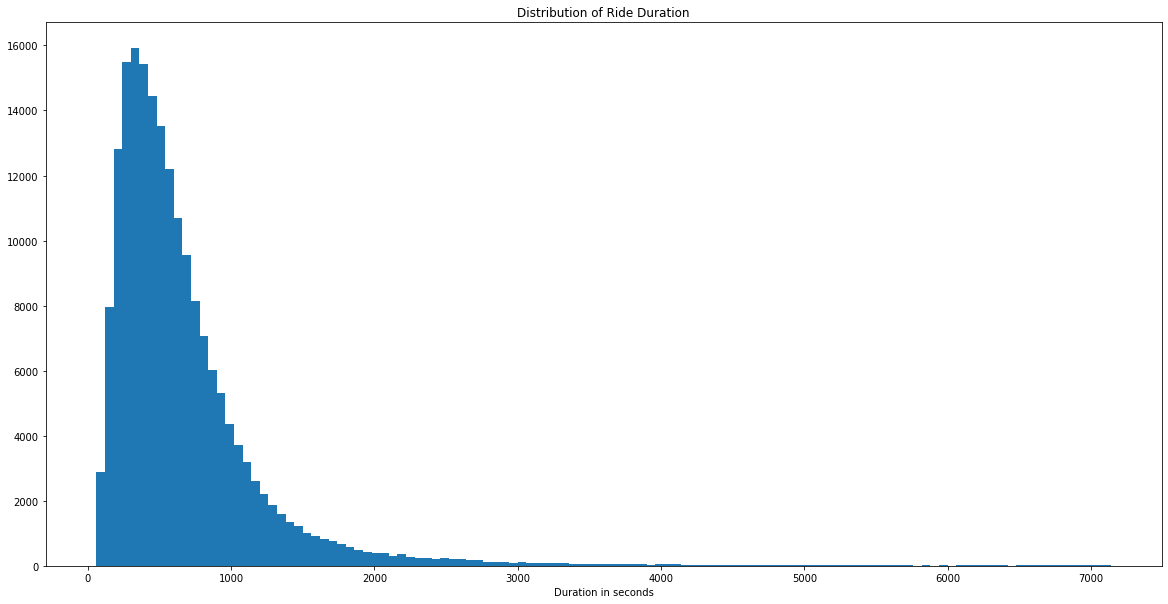

In [8]:
plt.figure(figsize=(20,10));
plt.hist(jan.duration_sec, bins = bin_values);
plt.title("Distribution of Ride Duration")
plt.xlabel("Duration in seconds")
plt.show();

In [9]:
print(jan[jan.duration_sec <= 1500].duration_sec.count()/jan.shape[0]*100)

93.48247102799846


In [10]:
print(1500/60)

25.0


Hire duration seems to be extremely right skewed with a long tail. There are a minority spread over the 30 minutes to 2 hour range, however the majority - 93.5% of the hires fall in the between 60 and 1500 seconds (25 minutes) duration.

### The distribution of bikes at the end of January

first off lets get the value counts for the start stations and the end stations 

324


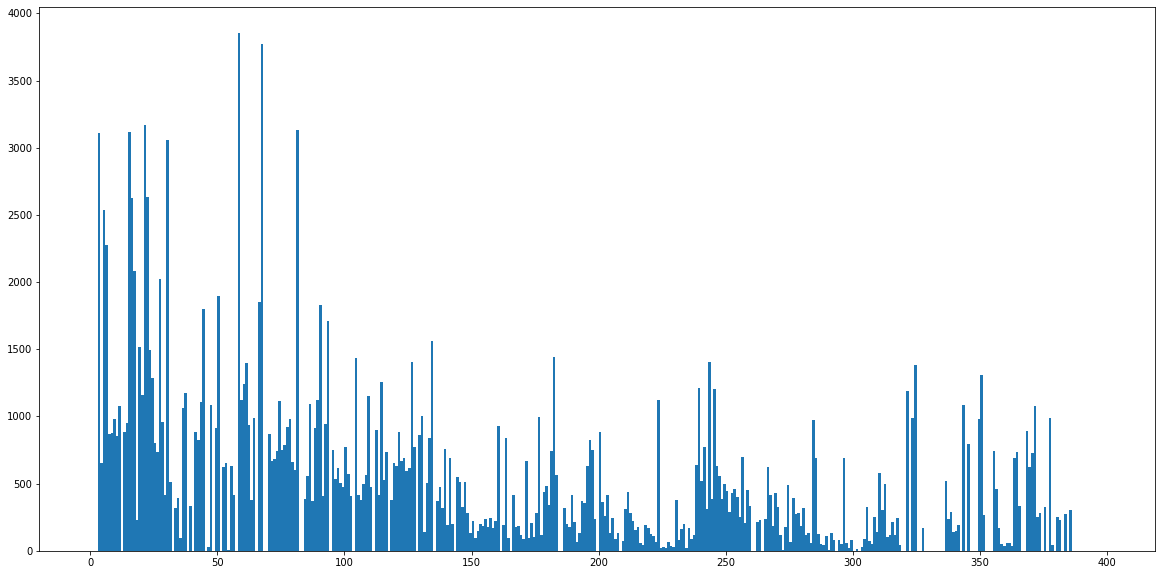

In [11]:
print(jan.start_station_id.nunique())
#check that there are no missing start station ids visually 
plt.figure(figsize=(20,10));
bin_values = np.arange(start=0, stop=400, step=1)
plt.hist(jan.start_station_id, bins = bin_values)
plt.show()

324


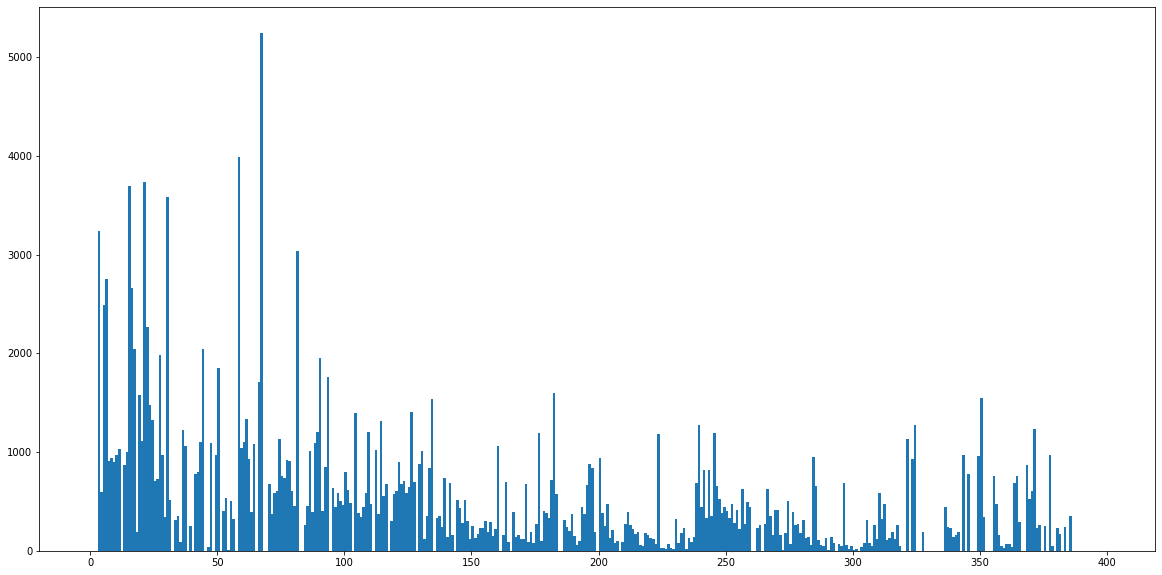

In [12]:
print(jan.end_station_id.nunique())
#check that there are no missing end station ids visually 
plt.figure(figsize=(20,10));
bin_values = np.arange(start=0, stop=400, step=1)
plt.hist(jan.end_station_id, bins = bin_values)
plt.show()

There appear to be some missing station numbers in the range of 1 to 385, the business might have made some odd choices in giving their stations ids. The stations will be dropped after merging if they only exist in one column. 

In [13]:
#start station tallies
start_series = jan.start_station_id.value_counts()
start_df = start_series.to_frame()
start_df.reset_index(inplace=True)
start_df.rename(columns={"index": "station_id", "start_station_id": "outflow"}, inplace=True)
start_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
station_id    324 non-null float64
outflow       324 non-null int64
dtypes: float64(1), int64(1)
memory usage: 5.1 KB


In [14]:
#end station tallies
end_series = jan.end_station_id.value_counts()
end_df = end_series.to_frame()
end_df.reset_index(inplace=True)
end_df.rename(columns={"index": "station_id", "end_station_id": "inflow"}, inplace=True)
end_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 324 entries, 0 to 323
Data columns (total 2 columns):
station_id    324 non-null float64
inflow        324 non-null int64
dtypes: float64(1), int64(1)
memory usage: 5.1 KB


In [15]:
#merge into one dataframe
flows = end_df.merge(start_df, on='station_id')

In [16]:
flows.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 324 entries, 0 to 323
Data columns (total 3 columns):
station_id    324 non-null float64
inflow        324 non-null int64
outflow       324 non-null int64
dtypes: float64(1), int64(2)
memory usage: 10.1 KB


In [17]:
flows['net_flow'] = flows['inflow'] - flows['outflow']
flows.station_id.nunique()

324

In [18]:
flows.sort_values('station_id', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')

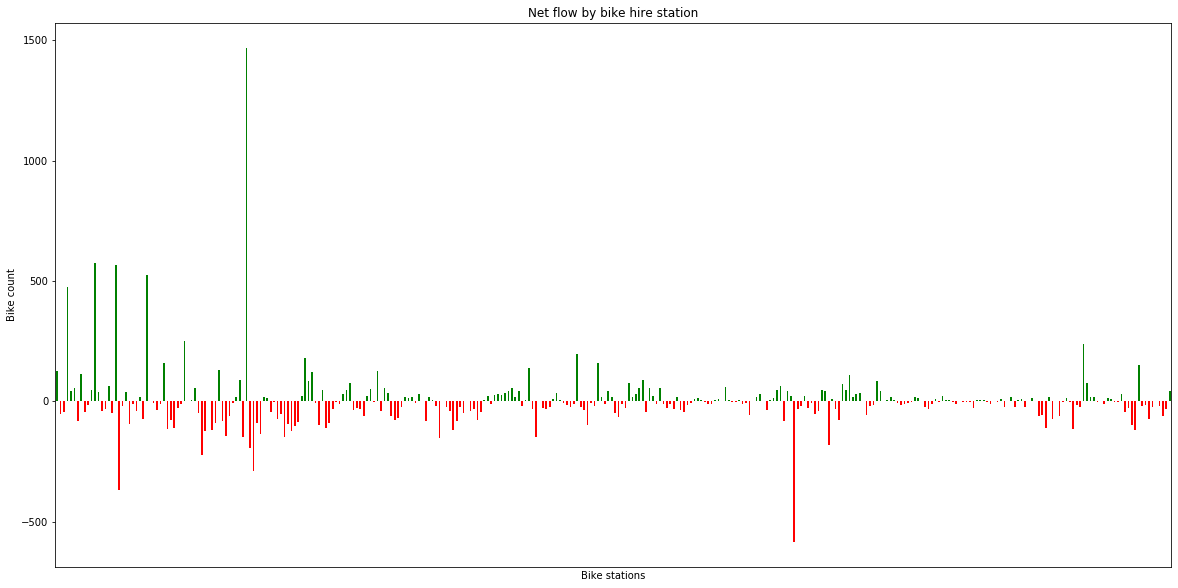

In [37]:
x = np.arange(10, 2)
plt.figure(figsize=(20,10));
flows['net_flow'].plot(kind='bar',color=(flows['net_flow'] > 0).map({True: 'g',False: 'r'}))
plt.xticks(x, "")
plt.title("Net flow by bike hire station")
plt.ylabel("Bike count")
plt.xlabel("Bike stations")
plt.show()

Now we get the result of the previous two histograms if they were superimposed on each other. A measure of net flows of each bike station. There are a number of significant stations in terms of bike drop offs. Which stations represent those out net outflows and inflows?

In [41]:
#find the stations accumulating bikes
flows.sort_values('net_flow', axis=0, ascending=False, inplace=True, kind='quicksort', na_position='last')
flows.head(10)

,station_id,inflow,outflow,net_flow
0,67.0,5244,3775,1469
3,15.0,3692,3115,577
2,21.0,3733,3166,567
4,30.0,3582,3055,527
7,6.0,2752,2278,474
11,44.0,2048,1799,249
20,350.0,1547,1309,238
34,176.0,1191,994,197
42,88.0,1095,914,181
31,36.0,1221,1061,160


In [42]:
#find the stations losing bikes
flows.sort_values('net_flow', axis=0, ascending=True, inplace=True, kind='quicksort', na_position='last')
flows.head(10)

,station_id,inflow,outflow,net_flow
76,243.0,818,1403,-585
10,22.0,2264,2634,-370
165,71.0,376,667,-291
155,52.0,400,623,-223
98,70.0,678,870,-192
195,253.0,278,458,-180
173,132.0,353,507,-154
92,163.0,693,842,-149
140,80.0,452,601,-149
17,66.0,1705,1852,-147
